# Reproduce the heatmap from inferCNV

This document demonstrates to reproduce how the [example heatmap](https://github.com/broadinstitute/inferCNV/wiki#demo-example-figure) from the original
R inverCNV implementation. It is based on a small, 183-cell example dataset of malignant and non-malignant cells from Oligodendroglioma derived from [Tirosh et al. (2016)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5465819/).

In [1]:
import infercnvpy as cnv
import scanpy as sc
import anndata as ad
from scipy.sparse import issparse
import numpy as np

## Prepare and inspect dataset

The example dataset is available in the `datasets` module. It is already TPM-normalized, but not log-transformed.

In [2]:
#adata_them = cnv.datasets.oligodendroglioma()
adata = ad.read("adata_snRNAseq2")
sc.pp.log1p(adata)
#sc.pp.log1p(adata_them)

It also already has the genomic positions annotated in`adata.var`:

#### Make sure the chromosomes are labeled as "chr1", "chr18", etc.

In [3]:
adata.var['chromosome'] = adata.var['chromosome'].apply(lambda x: 'chr' + str(x) if str(x).isnumeric() else x)

In [4]:
adata.var['chromosome'] = adata.var['chromosome'].apply(lambda x: 'chr' + str(x) if len(x)<2 else x)

In [5]:
adata.var['chromosome'].unique().tolist()

['chr3',
 'chr16',
 'chr11',
 'chr13',
 'chr4',
 'chr9',
 'chrY',
 'chr17',
 'chr7',
 'chrX',
 'chr5',
 'chr6',
 'chr2',
 'chr14',
 'chr10',
 'chr8',
 'chr15',
 'chr18',
 'chr1',
 'chr12',
 'chr19',
 'GL456233.1',
 'GL456221.1',
 'GL456216.1',
 'MT',
 'GL456211.1',
 'GL456210.1',
 'JH584304.1',
 'JH584299.1',
 'JH584297.1']

It contains four types of malignant cells, and two clusters of non-malignant cells.

/Users/carmen.robinson/miniconda3/envs/cnv/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


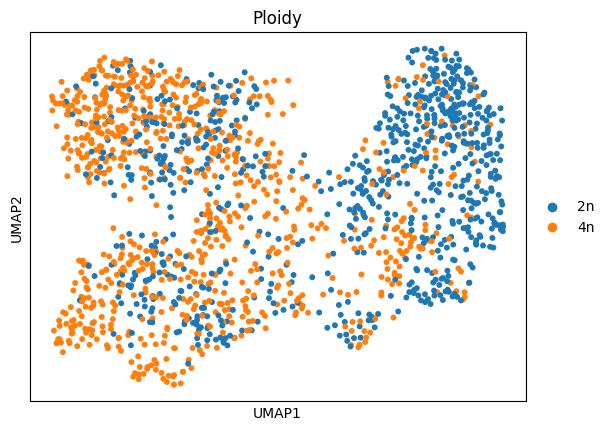

In [11]:
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata
           , color="Ploidy")

In [21]:
diploidHeps  = []
for i in range(0, len(adata)):
    if ( adata.obs["Ploidy"][i] == "2n" and adata.obs['cell_type'][i] == 'Hepatocytes'):
        diploidHeps.append(1)
    else: 
        diploidHeps.append(0)

adata.obs["diploidHep"] = diploidHeps

In [18]:
adata.obs["cell_type"].unique().tolist()

['B-cells',
 'Stellate cells',
 'Hepatocytes',
 'Hepatobiliary cells',
 'T-cells',
 'Plasma B-cells',
 'Endothelial cells',
 'Kupffer and dendritic cells',
 'Epcam+ epithelial cells']

## Run infercnvpy

In this case we know which cells are non-malignant. For best results, it is recommended to use
the non-malignant cells as a background. We can provide this information using `reference_key` and `reference_cat`.

In order to reproduce the results as exactely as possible, we use a `window_size` of 100 and a `step` of 1.

# Troubleshooting

In [25]:
%%time
cnv.tl.infercnv(
    adata,
    reference_key="diploidHep",
    reference_cat=[1],
    window_size=100,
    step=1,
)

  0%|          | 0/1 [00:00<?, ?it/s]

CPU times: user 227 ms, sys: 194 ms, total: 422 ms
Wall time: 8.56 s


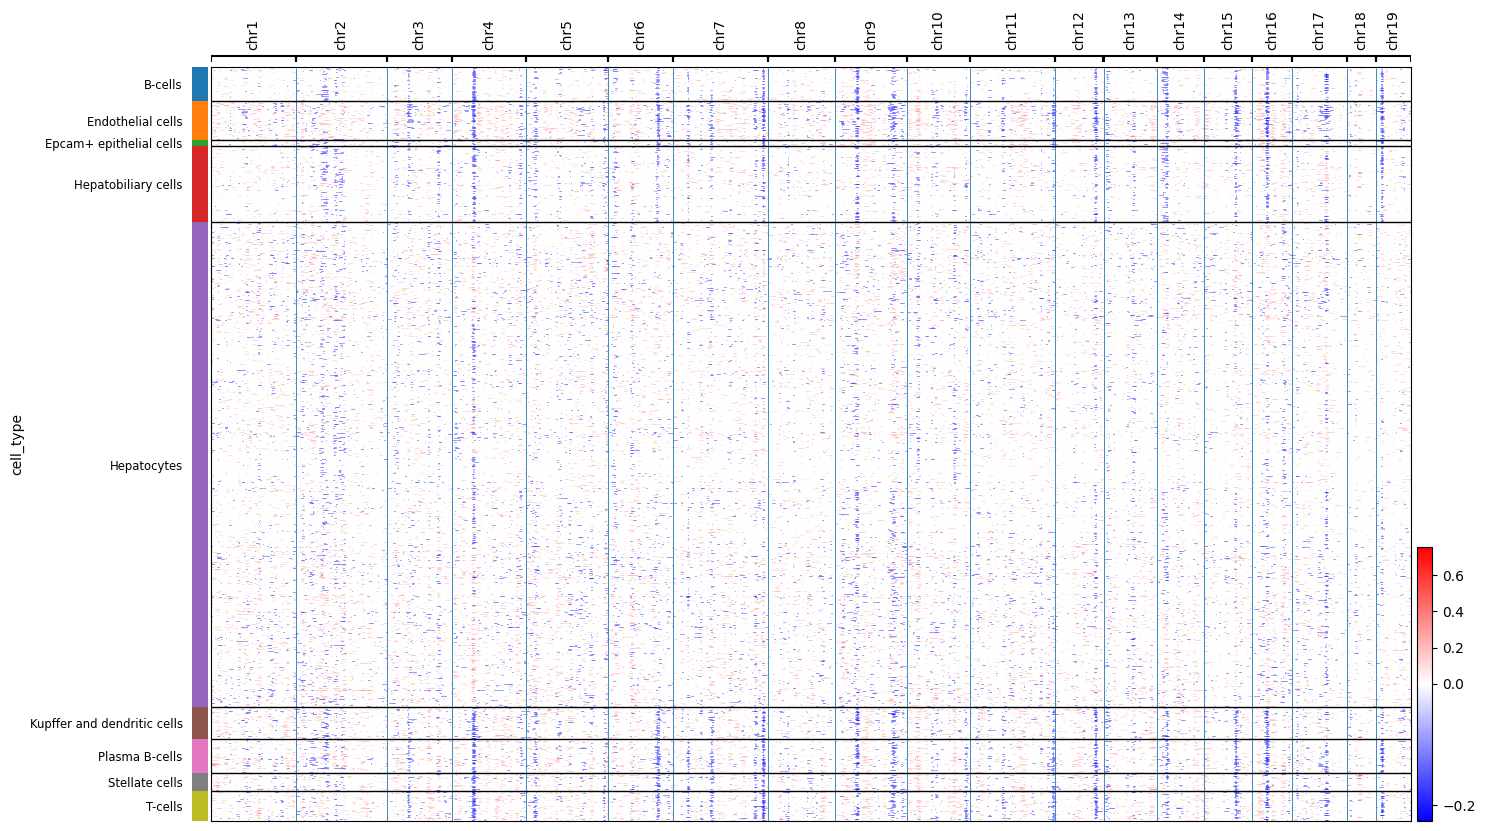

CPU times: user 3.3 s, sys: 1.39 s, total: 4.69 s
Wall time: 4.55 s


In [27]:
%%time
cnv.pl.chromosome_heatmap(adata, groupby="cell_type", dendrogram=False)

Note that running the same analysis in R (`invercnv v1.6.0` from Bioconductor) takes about 1:30 min.